In [26]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio

import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

from sklearnex import patch_sklearn  # Intel CPU acceleration for sklearn
patch_sklearn()

cuda


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
tracks = pd.read_csv("../data/fma_metadata/tracks.csv", index_col=0, header=[0,1])
tracks = tracks[tracks["set", "subset"] == "small"]
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
140             1  2008-11-26 01:49:59  2007-05-22 00:00:00      NaN   
141             0  2008-11-26 01:49:57  2009-01-16 00:00:00      NaN   

                                                                           \
         favorites  id                                        information   
track_id                                                                    
2                4   1                                            <p></p>   
5                4   1                                            <p></p>   
10               4   6                                                NaN   
140              1  61  <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...   
141              1  60  <p>A full ensamble of strings, drums, electron...   

                                                       ...       track  \
         listens                        producer tags  ... information   
track_id                                               ...               
2           6073                             NaN   []  ...         NaN   
5           6073                             NaN   []  ...         NaN   
10         47632                             NaN   []  ...         NaN   
140         1300  Alec K. Refearn, Rob Pemberton   []  ...         NaN   
141         1304                             NaN   []  ...         NaN   

                                 \
         interest language_code   
track_id                          
2            4656            en   
5            1933            en   
10          54881            en   
140          1593            en   
141           839            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
140       Attribution-Noncommercial-No Derivative Works ...    1299      NaN   
141       Attribution-Noncommercial-No Derivative Works ...     725      NaN   

                                                    
         number publisher tags               title  
track_id                                            
2             3       NaN   []                Food  
5             6       NaN   []          This World  
10            1       NaN   []             Freeway  
140           2       NaN   []  Queen Of The Wires  
141           4       NaN   []                Ohio  

[5 rows x 52 columns]

In [218]:
from sklearn.preprocessing import LabelEncoder

features = pd.read_csv("../features/fma_features_3sec.csv", index_col=0, header=[0,1,2,3])
# Restrict to small subset
features = features.loc[tracks.index]
# Join in genre column -- since columns are MultiIndexed, we have to add extra levels
label2idx = LabelEncoder().fit(tracks["track", "genre_top"])
features["track", "genre_top", "", ""] = label2idx.transform(tracks["track", "genre_top"])
# Remove rows with NaNs (corrupted tracks)
features.dropna(inplace=True)
print(features.shape)
features.head()

(7994, 3701)


feature        chroma_cens                                                    \
statistics             max                                                     
feature_number          01                                                     
song_pos            pos_01    pos_02    pos_03    pos_04    pos_05    pos_06   
track_id                                                                       
2                 0.704124  0.670529  0.731929  0.699341  0.558846  0.546863   
5                 0.386654  0.396511  0.430391  0.420343  0.459678  0.469663   
10                0.413630  0.393576  0.306028  0.380294  0.286272  0.330367   
140               0.474108  0.244633  0.398619  0.297416  0.225072  0.398411   
141               0.519412  0.436285  0.505933  0.355401  0.042728  0.354588   

feature                                                 ...       zcr  \
statistics                                              ...       std   
feature_number                                          ...        01   
song_pos          pos_07    pos_08    pos_09    pos_10  ...    pos_02   
track_id                                                ...             
2               0.557567  0.506822  0.622437  0.661271  ...  0.086403   
5               0.421741  0.440108  0.470912  0.503388  ...  0.045397   
10              0.319100  0.301520  0.253617  0.360578  ...  0.034129   
140             0.228512  0.241962  0.398566  0.521293  ...  0.026601   
141             0.371628  0.409198  0.254998  0.441377  ...  0.015979   

feature                                                                     \
statistics                                                                   
feature_number                                                               
song_pos          pos_03    pos_04    pos_05    pos_06    pos_07    pos_08   
track_id                                                                     
2               0.061894  0.071970  0.069562  0.050927  0.044658  0.055987   
5               0.051211  0.040011  0.036974  0.029119  0.041461  0.033762   
10              0.020003  0.018932  0.016606  0.015600  0.018541  0.018028   
140             0.033925  0.023193  0.039791  0.038043  0.039282  0.007803   
141             0.045776  0.044014  0.021849  0.030574  0.014621  0.011454   

feature                                track  
statistics                         genre_top  
feature_number                                
song_pos          pos_09    pos_10            
track_id                                      
2               0.066270  0.089225         3  
5               0.072484  0.060742         3  
10              0.018082  0.014767         6  
140             0.014162  0.064145         2  
141             0.022677  0.026572         2  

[5 rows x 3701 columns]

In [221]:
print(pd.Series(label2idx.classes_))

0       Electronic
1     Experimental
2             Folk
3          Hip-Hop
4     Instrumental
5    International
6              Pop
7             Rock
dtype: object


In [232]:
train = features[tracks["set", "split"] == "training"]
valid = features[tracks["set", "split"] == "validation"]
test = features[tracks["set", "split"] == "test"]
print(train.shape, valid.shape, test.shape)

(6394, 3701) (800, 3701) (800, 3701)


/tmp/ipykernel_113094/3773691276.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = features[tracks["set", "split"] == "training"]
/tmp/ipykernel_113094/3773691276.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid = features[tracks["set", "split"] == "validation"]
/tmp/ipykernel_113094/3773691276.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = features[tracks["set", "split"] == "test"]


## PyTorch neural network model

In [260]:
from torch.utils.data import Dataset

class AudioFeaturesDataset(Dataset):
    def __init__(self, df, chosen_features=slice(None)):
        self.df = df
        self.chosen_features = chosen_features
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        X = torch.tensor(self.df.iloc[i][self.chosen_features].values, dtype=torch.float)
        y = torch.tensor(self.df.iloc[i]["track", "genre_top", "", ""], dtype=torch.long)
        return X, y

In [275]:
chosen_features = (slice(None), "mean", slice(None), slice(None))
train_dset = AudioFeaturesDataset(train, chosen_features)
valid_dset = AudioFeaturesDataset(valid, chosen_features)
test_dset = AudioFeaturesDataset(test, chosen_features)
len(train_dset)

6394

In [276]:
train_dset[0][0].shape

torch.Size([740])

In [277]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False)
next(iter(train_loader))

[tensor([[0.1046, 0.2495, 0.3911,  ..., 0.0686, 0.0657, 0.0528],
         [0.1734, 0.1492, 0.1476,  ..., 0.0652, 0.0737, 0.0714],
         [0.2330, 0.2158, 0.1400,  ..., 0.0387, 0.0488, 0.0859],
         ...,
         [0.0558, 0.0083, 0.0123,  ..., 0.0706, 0.0665, 0.0582],
         [0.0148, 0.0192, 0.0165,  ..., 0.0255, 0.0313, 0.0299],
         [0.3062, 0.2247, 0.3782,  ..., 0.0283, 0.0314, 0.0429]]),
 tensor([7, 7, 1, 6, 7, 4, 4, 5, 2, 7, 0, 5, 7, 7, 2, 0, 4, 1, 5, 7, 4, 1, 2, 3,
         2, 6, 0, 4, 3, 7, 6, 7])]

In [246]:
from torch import nn
class BasicNetwork(nn.Module):
    def __init__(self, in_features, dim_hidden, num_hidden_layers, num_classes=8):
        super().__init__()
        self.input = nn.Linear(in_features, dim_hidden)
        layers = [nn.ReLU()]
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(dim_hidden, dim_hidden, dtype=torch.float))
            layers.append(nn.ReLU())
        self.hidden = nn.ModuleList(layers)
        self.output = nn.Linear(dim_hidden, num_classes, dtype=torch.float)
    
    def forward(self, x):
        x = self.input(x)
        for layer in self.hidden:
            x = layer(x) + x
        x = self.output(x)
        return x
                           


In [286]:
model = BasicNetwork(
    in_features=740,
    dim_hidden=100,
    num_hidden_layers=5,
).to(DEVICE)
    

In [279]:
X, y = next(iter(train_loader))
model(X.to(DEVICE)).shape

torch.Size([32, 8])

 62%|███████████████████████████▎                | 62/100 [00:03<00:02, 17.03it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.51E-05


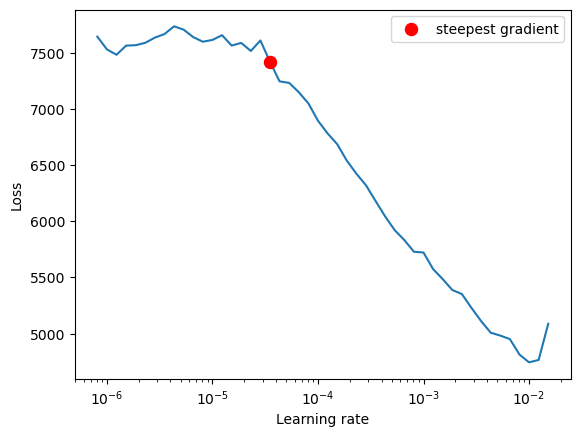

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 3.51119173421513e-05)

In [280]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot()


In [207]:
lr_finder.reset()

In [287]:
from sklearn.metrics import f1_score, accuracy_score
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
epochs = 100
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 1e-4, 
    epochs=epochs,
    steps_per_epoch=len(train_loader),
)
labels = np.arange(len(label2idx.classes_))

for i in range(epochs):
    train_loss, valid_loss = 0, 0
    train_preds = np.array([])
    train_true = np.array([])
    valid_preds = np.array([])
    valid_true = np.array([])
    for X, y in train_loader:
        optimizer.zero_grad()
        y_logit = model(X.to(DEVICE))
        loss = criterion(y_logit, y.to(DEVICE))
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        y_pred = y_logit.argmax(dim=1).detach().cpu().numpy()
        train_preds = np.hstack([train_preds, y_pred])
        train_true = np.hstack([train_true, y.cpu().numpy()])
    train_acc = accuracy_score(train_true, train_preds)
    train_f1 = f1_score(train_true, train_preds, labels=labels, average="macro")
    for X, y in valid_loader:
        with torch.inference_mode():
            y_logit = model(X.to(DEVICE))
            loss = criterion(y_logit, y.to(DEVICE))
        
        valid_loss += loss.item()
        y_pred = y_logit.argmax(dim=1).detach().cpu().numpy()
        valid_preds = np.hstack([valid_preds, y_pred])
        valid_true = np.hstack([valid_true, y.cpu().numpy()])
    valid_acc = accuracy_score(valid_true, valid_preds)
    valid_f1 = f1_score(valid_true, valid_preds, labels=labels, average="macro")
        
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f"Epoch {i:>3} | Train loss {train_loss:>8.3f}, accuracy {train_acc:>4.3f}, F1 {train_f1:>4.3f} "
          f"| Valid loss {valid_loss:>8.3f}, accuracy {valid_acc:4.3f}, F1 {valid_f1:>4.3f}")
    

Epoch   0 | Train loss 6961.262, accuracy 0.135, F1 0.086 | Valid loss 2899.881, accuracy 0.087, F1 0.064
Epoch   1 | Train loss 1795.572, accuracy 0.128, F1 0.119 | Valid loss 1380.149, accuracy 0.124, F1 0.119
Epoch   2 | Train loss 1173.381, accuracy 0.177, F1 0.176 | Valid loss 1085.185, accuracy 0.158, F1 0.153
Epoch   3 | Train loss  957.114, accuracy 0.190, F1 0.188 | Valid loss  866.345, accuracy 0.182, F1 0.181
Epoch   4 | Train loss  765.392, accuracy 0.201, F1 0.200 | Valid loss  670.988, accuracy 0.212, F1 0.208
Epoch   5 | Train loss  607.821, accuracy 0.221, F1 0.220 | Valid loss  554.975, accuracy 0.240, F1 0.231
Epoch   6 | Train loss  501.979, accuracy 0.236, F1 0.235 | Valid loss  446.895, accuracy 0.251, F1 0.239
Epoch   7 | Train loss  401.054, accuracy 0.255, F1 0.255 | Valid loss  357.149, accuracy 0.279, F1 0.275
Epoch   8 | Train loss  340.210, accuracy 0.265, F1 0.264 | Valid loss  342.696, accuracy 0.260, F1 0.243
Epoch   9 | Train loss  294.330, accuracy 0.27

In [296]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8, weight_decay=1e-2)
epochs = 200
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 1e-6, 
    epochs=epochs,
    steps_per_epoch=len(train_loader),
)
labels = np.arange(len(label2idx.classes_))

for i in range(100, epochs):
    train_loss, valid_loss = 0, 0
    train_preds = np.array([])
    train_true = np.array([])
    valid_preds = np.array([])
    valid_true = np.array([])
    for X, y in train_loader:
        optimizer.zero_grad()
        y_logit = model(X.to(DEVICE))
        loss = criterion(y_logit, y.to(DEVICE))
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        y_pred = y_logit.argmax(dim=1).detach().cpu().numpy()
        train_preds = np.hstack([train_preds, y_pred])
        train_true = np.hstack([train_true, y.cpu().numpy()])
    train_acc = accuracy_score(train_true, train_preds)
    train_f1 = f1_score(train_true, train_preds, labels=labels, average="macro")
    for X, y in valid_loader:
        with torch.inference_mode():
            y_logit = model(X.to(DEVICE))
            loss = criterion(y_logit, y.to(DEVICE))
        
        valid_loss += loss.item()
        y_pred = y_logit.argmax(dim=1).detach().cpu().numpy()
        valid_preds = np.hstack([valid_preds, y_pred])
        valid_true = np.hstack([valid_true, y.cpu().numpy()])
    valid_acc = accuracy_score(valid_true, valid_preds)
    valid_f1 = f1_score(valid_true, valid_preds, labels=labels, average="macro")
        
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f"Epoch {i:>3} | Train loss {train_loss:>8.3f}, accuracy {train_acc:>4.3f}, F1 {train_f1:>4.3f} "
          f"| Valid loss {valid_loss:>8.3f}, accuracy {valid_acc:4.3f}, F1 {valid_f1:>4.3f}")
    

Epoch 100 | Train loss   10.578, accuracy 0.523, F1 0.523 | Valid loss   28.707, accuracy 0.343, F1 0.343
Epoch 101 | Train loss   10.578, accuracy 0.525, F1 0.525 | Valid loss   28.738, accuracy 0.344, F1 0.344
Epoch 102 | Train loss   10.572, accuracy 0.523, F1 0.523 | Valid loss   28.732, accuracy 0.340, F1 0.339
Epoch 103 | Train loss   10.570, accuracy 0.525, F1 0.524 | Valid loss   28.745, accuracy 0.344, F1 0.345
Epoch 104 | Train loss   10.582, accuracy 0.524, F1 0.524 | Valid loss   28.760, accuracy 0.345, F1 0.345
Epoch 105 | Train loss   10.570, accuracy 0.525, F1 0.525 | Valid loss   28.726, accuracy 0.345, F1 0.346
Epoch 106 | Train loss   10.576, accuracy 0.524, F1 0.524 | Valid loss   28.770, accuracy 0.343, F1 0.345
Epoch 107 | Train loss   10.587, accuracy 0.522, F1 0.522 | Valid loss   28.767, accuracy 0.344, F1 0.346
Epoch 108 | Train loss   10.586, accuracy 0.523, F1 0.523 | Valid loss   28.771, accuracy 0.344, F1 0.344
Epoch 109 | Train loss   10.584, accuracy 0.52

## XGBoost

In [316]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

chosen_features = (slice(None), slice(None), slice(None), slice(None))

X_train, y_train = train.loc[:, chosen_features], train.iloc[:, -1]
X_valid, y_valid = valid.loc[:, chosen_features], valid.iloc[:, -1]
X_test, y_test = test.loc[:, chosen_features], test.iloc[:, -1]

X_tt, X_tv, y_tt, y_tv = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=4)

model = XGBClassifier(
    device="cuda",
    max_depth=3,
    early_stopping_rounds=20,
    n_estimators=1000,
    learning_rate=0.05,
    objective="multi:softmax",
)

model.fit(X_tt, y_tt, eval_set=[(X_tv, y_tv)])

/home/pvk/miniconda3/envs/audiobot/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:54:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "metric" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.88371
[1]	validation_0-mlogloss:1.72351
[2]	validation_0-mlogloss:1.58785
[3]	validation_0-mlogloss:1.47041
[4]	validation_0-mlogloss:1.36706
[5]	validation_0-mlogloss:1.27495
[6]	validation_0-mlogloss:1.19206
[7]	validation_0-mlogloss:1.11690
[8]	validation_0-mlogloss:1.04831
[9]	validation_0-mlogloss:0.98539
[10]	validation_0-mlogloss:0.92741
[11]	validation_0-mlogloss:0.87380
[12]	validation_0-mlogloss:0.82407
[13]	validation_0-mlogloss:0.77782
[14]	validation_0-mlogloss:0.73469
[15]	validation_0-mlogloss:0.69441
[16]	validation_0-mlogloss:0.65671
[17]	validation_0-mlogloss:0.62137
[18]	validation_0-mlogloss:0.58820
[19]	validation_0-mlogloss:0.55703
[20]	validation_0-mlogloss:0.52771
[21]	validation_0-mlogloss:0.50009
[22]	validation_0-mlogloss:0.47407
[23]	validation_0-mlogloss:0.44952
[24]	validation_0-mlogloss:0.42636
[25]	validation_0-mlogloss:0.40447
[26]	validation_0-mlogloss:0.38380
[27]	validation_0-mlogloss:0.36424
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              metric='mlogloss', min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [317]:
from sklearn.metrics import log_loss, accuracy_score, f1_score
y_train_prob = model.predict_proba(X_train)
y_train_pred = model.predict(X_train)
y_valid_prob = model.predict_proba(X_valid)
y_valid_pred = model.predict(X_valid)

train_loss = log_loss(y_train, y_train_prob)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, labels=np.arange(len(label2idx.classes_)), average="macro")
valid_loss = log_loss(y_valid, y_valid_prob)
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred, labels=np.arange(len(label2idx.classes_)), average="macro")
print(f"Train loss {train_loss:>8.3f}, accuracy {train_acc:>4.3f}, F1 {train_f1:>4.3f} "
      f"| Valid loss {valid_loss:>8.3f}, accuracy {valid_acc:4.3f}, F1 {valid_f1:>4.3f}")

Train loss    0.001, accuracy 1.000, F1 1.000 | Valid loss    0.001, accuracy 1.000, F1 1.000


In [318]:
y_test_prob = model.predict_proba(X_test)
y_test_pred = model.predict(X_test)

test_loss = log_loss(y_test, y_test_prob)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, labels=np.arange(len(label2idx.classes_)), average="macro")
print(f"Test loss {test_loss:>8.3f}, accuracy {test_acc:4.3f}, F1 {test_f1:>4.3f}")

Test loss    0.001, accuracy 1.000, F1 1.000


In [320]:
(y_test != y_test_pred).sum()

0